In [102]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pylab
import scipy as sp
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from drift.core import manager
from scipy.sparse import lil_matrix
import sys
sys.path.insert(0,'/home/zahra/PIPELINE')
from cora.util import hputil
from astropy.stats import gaussian_fwhm_to_sigma
from hirax_transfer.beams import separations
import healpy as hp
from cora.core import skysim
from cora.foreground import gaussianfg, galaxy
from log_red_cal_fewer_redblocks import Logcal_solutions, A_matrix, colour_scatterplot, Bls_counts, Scatterplot
from cora.foreground import gaussianfg, galaxy
from cora.util import coord
from drift.core import visibility
sys.path.insert(0,'/home/zahra/hirax_tools/')
from hirax_tools import array_config

In [103]:
Ndish=25
Nbls=Ndish*(Ndish-1)/2

#m=manager.ProductManager.from_config('/home/zahra/PIPELINE/5by5_dishvar_pt1_kl/prod_params_custom.yaml')
m=manager.ProductManager.from_config('/home/zahra/PIPELINE/example_5by5_kl_nodishscatter_lmax_200/prod_params_custom.yaml')

#m=manager.ProductManager.from_config('/media/zahra/DATA/5by5_dishvar_pt01/prod_params_custom.yaml')


correlation_arr, sum_counts, arranged_corr_counts, arranged_corr_unique_bls = Bls_counts(m)

#m=manager.ProductManager.from_config('/home/zahra/PIPELINE/example_8by8/prod_params_custom.yaml')

t=m.telescope
x=t.feedpositions[:,0] #these are x and y positions not x and y polarizations
y=t.feedpositions[:,1]

Product directory: /home/zahra/PIPELINE/example_5by5_kl_nodishscatter_lmax_200/bt_matrices


In [104]:
runs=100
time_channel=400
sigma = 0.001
sky = 1.
dish_fluc = 5.

In [105]:
lmax = t.lmax
mmax = t.mmax
nside = 128
print nside
angpos = hputil.ang_positions(nside)
zenith = t.zenith #same as np.radians(120)
frequencies = t.frequencies
print zenith
print angpos

128
[2.0943951 0.       ]
[[0.00637889 0.78539816]
 [0.00637889 2.35619449]
 [0.00637889 3.92699082]
 ...
 [3.13521376 2.35619449]
 [3.13521376 3.92699082]
 [3.13521376 5.49778714]]


In [106]:
wavelength = (3.e8)/(600.*10.**6)
fwhm = 1.*wavelength/6.
sigma_beam = gaussian_fwhm_to_sigma*fwhm
seps = separations(angpos, zenith)
beammodel = np.exp(-seps**2/2/sigma_beam**2)
print beammodel

[0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 1.61922971e-192
 1.61922971e-192 3.05744225e-189]


In [107]:
sph_arr = coord.sph_to_cart(angpos)
uhatc, vhatc = visibility.uv_plane_cart(zenith)


In [108]:
HAC = array_config.HIRAXArrayConfig.from_n_elem_compact(Ndish, 6.)


#uv = np.resize(np.repeat(3, sph_arr.shape[0]),(3, )
#print uv.shape

vis_all = np.array([])
fringes_all = np.array([])

for i in correlation_arr:
    dish_0, dish_1 = i
    bl_ind = [np.int(dish_0), np.int(dish_1)]
    #v_coord, u_coord, _ = HAC.uvw_coords(frequencies[0],bl_ind)
    u_coord = (x[bl_ind[0]] - x[bl_ind[1]])/wavelength
    #print u_coord, 'u'
    v_coord = (y[bl_ind[0]] - y[bl_ind[1]])/wavelength
    #print v_coord, 'v'
    uv = u_coord * uhatc + v_coord * vhatc
    #print np.inner(sph_arr[0], uv), 'print '
    #print np.exp(np.inner(sph_arr[0], uv)), 'exp'
    fringes_ind = np.exp(1j*2*np.pi*np.sum(np.inner(sph_arr, uv)))
    vis_ind = np.sum(beammodel**2*fringes_ind*sky)
    vis_all = np.append(vis_all, np.round(vis_ind, 3))
    fringes_all = np.append(fringes_all, fringes_ind)

In [109]:
vis_ = vis_all

vis_new = np.zeros(300, dtype= 'complex')
vis_new[:188] += vis_[:188]

vis_new[188:196] += vis_[188:196]
vis_new[196:204] += vis_[204:212]
vis_new[204:212] += vis_[196:204]
vis_new[212:220] += vis_[212:220]

vis_new[220:226] += vis_[220:226]
vis_new[226:232] += vis_[232:238]
vis_new[232:238] += vis_[226:232]
vis_new[238:244] += vis_[238:244]

vis_new[244:254] += vis_[244:254]

vis_new[254:258] += vis_[254:258]
vis_new[258:262] += vis_[262:266]
vis_new[262:266] += vis_[258:262]
vis_new[266:270] += vis_[266:270]

vis_new[270:274] += vis_[270:274]
vis_new[274:278] += vis_[274:278]

vis_new[278:281] += vis_[278:281]
vis_new[281:284] += vis_[284:287]
vis_new[284:287] += vis_[281:284]
vis_new[287:290] += vis_[287:290]

vis_new[290:292] += vis_[290:292]
vis_new[292:294] += vis_[294:296]
vis_new[294:296] += vis_[292:294]
vis_new[296:298] += vis_[296:298]

vis_new[298:299] += vis_[298:299]
vis_new[299:300] += vis_[299:300]


In [110]:
arranged_corr_counts = np.load('arranged_corr_counts_5by5_24_red_blocks.npy')
lims = np.append(0, np.cumsum(arranged_corr_counts))

arranged_corr_unique_bls = np.load('arranged_corr_unique_bls_5by5_24_red_blocks.npy')
correlation_arr = np.load('corr_arr_5by5_24_red_blocks.npy')

In [111]:
vis_newer_real = np.zeros(300)
vis_newer_imag = np.zeros(300)

for i in range(len(lims)-1):
    vis_newer_real[lims[i]:lims[i+1]] += np.random.normal(vis_new.real[lims[i]], dish_fluc, arranged_corr_counts[i])
    vis_newer_imag[lims[i]:lims[i+1]] += np.random.normal(vis_new.imag[lims[i]], dish_fluc, arranged_corr_counts[i])
    

In [112]:
vis_newer_real.shape

(300,)

In [113]:
vis_newer = np.array([])
for element in range(300):
    vis_newer = np.append(vis_newer,complex(vis_newer_real[element], vis_newer_imag[element]))

In [114]:
vis_new = vis_newer

In [115]:
def Measured_vis(sigma):
    mu = 0  
    N_real=np.random.normal(mu, sigma, Nbls)
    N_imag=np.random.normal(mu, sigma, Nbls)
    N_comp=np.array([])
    for i in range(len(N_real)):
        N_comp=np.append(N_comp,complex(N_real[i],N_imag[i]))
    meas_vis=vis_new+N_comp
    return meas_vis

meas_vis=Measured_vis(sigma)

In [116]:
meas_vis

array([59.27581746-1.20554018e+00j, 65.75961214+3.31814361e+00j,
       62.30659509-5.99799000e+00j, 70.21410995-4.48344237e+00j,
       58.47414211-7.38355534e+00j, 64.91523141+2.35571113e+00j,
       55.37403806+1.21570873e+00j, 64.69116701-8.37315841e-01j,
       62.34032061-1.93398216e+00j, 62.58766917-3.31889967e+00j,
       59.68008828+4.71569060e+00j, 63.84381859-4.13517591e+00j,
       53.24573603-2.20676377e+00j, 59.74347682+3.10395237e+00j,
       66.64094703+6.87043349e+00j, 56.64791822+4.63018871e+00j,
       60.30493486-3.25657478e-01j, 63.67432747+7.75529481e+00j,
       69.23778881-1.18501026e+00j, 61.94936498+7.80794632e+00j,
       67.98762596+3.22646377e+00j, 71.309935  -7.64465049e-01j,
       59.38974875-3.57146211e+00j, 61.32563458-2.35686643e+00j,
       62.334125  -7.52881509e+00j, 56.54915962-2.14720726e+00j,
       63.9682054 -3.79056397e+00j, 62.26957854-6.08087282e+00j,
       64.13771651-7.76810434e-01j, 67.40849357+1.79921549e+00j,
       59.58209122+7.1312

In [117]:
rg_2=h5py.File('/home/zahra/PIPELINE/example_5by5_kl_nodishscatter_lmax_200/draco_synthesis_no_fluc/rand_gains/sig_2.h5','r')
rg = rg_2['gain'][0,:,time_channel]
gain=rg[:Ndish]

In [118]:
x_true_real = Logcal_solutions(m,vis_new,vis_new, gain,meas_vis, sigma)[2]

In [119]:
runs=10


gg=np.zeros((runs,Ndish))
for ind_run in range(runs):
    meas_vis = Measured_vis(sigma)    
    gg[ind_run,:] = Logcal_solutions(m,vis_new,vis_new, gain,meas_vis, sigma)[0][:Ndish]  #5 for manual noise, 8 for gaussian noise 


In [120]:
print x_true_real[:Ndish]
print gg

[-3.22442073e-11 -1.13413168e-10 -6.73566758e-11 -7.89219801e-11
 -2.61305866e-10  4.32882619e-11 -1.03029918e-10 -2.25613972e-11
  1.90125693e-11 -1.31296085e-11  7.87891974e-11  9.91304816e-11
 -8.46749337e-11 -4.63282745e-11 -5.34094990e-11  6.01076966e-11
  1.63216329e-10 -1.79231074e-11 -1.04244391e-10 -6.74572620e-11
 -4.73963091e-11 -5.26222399e-11  1.10337961e-10 -1.56651803e-10
 -1.30448763e-10]
[[ 0.00713372  0.01111484 -0.01009846  0.01301956  0.02029037 -0.00585175
   0.03464198 -0.00032187 -0.03455901 -0.0240159  -0.01304126  0.02629662
  -0.00169182 -0.00012636  0.00711584 -0.00551558 -0.03949523  0.01768589
  -0.02173591 -0.02206993  0.01596355  0.00781322  0.03220463 -0.01256609
  -0.00220418]
 [ 0.00712776  0.01111794 -0.01009226  0.01301861  0.0202837  -0.00584888
   0.03464079 -0.00031662 -0.03455091 -0.02401972 -0.01304483  0.02629399
  -0.00168991 -0.00012565  0.00712299 -0.00551414 -0.03948903  0.01769662
  -0.02173829 -0.02206755  0.01595879  0.00781107  0.032205

In [121]:
gg_logcal, sim_gains_logcal = gg, x_true_real[:Ndish]
def gains_mean_and_rel_err(gg,sim_gains_amp):
    gain_std=(np.std(gg,axis=0)/np.sqrt(runs)).flatten()
    gain_mean=np.mean(gg,axis=0).flatten() #shape is 98, we take every second one for amp so shape is 49
    rec_gains_mean_amp=gain_mean
    rec_gains_std_amp=gain_std
    rel_err_amp=np.abs(rec_gains_mean_amp-sim_gains_amp)/(sim_gains_amp)
    rel_err_amp_mean=np.mean(rel_err_amp)
    rel_err_amp_std=np.std(rel_err_amp,ddof=1)
    return rec_gains_mean_amp, rec_gains_std_amp, rel_err_amp, rel_err_amp_mean, rel_err_amp_std

rec_gains_mean_amp_2,_,rel_err_amp_2, rel_err_amp_mean_2 ,rel_err_amp_std_2 = gains_mean_and_rel_err(np.exp(gg_logcal),np.exp(sim_gains_logcal))
#rec_gains_mean_amp_2,_,rel_err_amp_2, rel_err_amp_mean_2 ,rel_err_amp_std_2 = gains_mean_and_rel_err(gg_logcal,1+sim_gains_logcal)

print rel_err_amp_mean_2, rel_err_amp_std_2

0.015455876428236143 0.011476395907837618


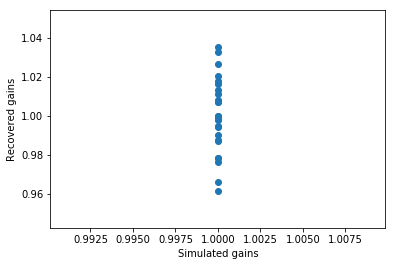

In [122]:
fig, ax = plt.subplots()

ax.scatter(np.exp(sim_gains_logcal),rec_gains_mean_amp_2)
#ax.plot(lims, lims,'g')
#plt.errorbar(x_true_real[:Ndish,time_channel],x_rec_real[:Ndish,time_channel],xerr=None,yerr=error[:Ndish],linestyle="None")
plt.xlabel('Simulated gains')
plt.ylabel('Recovered gains')
lim=.002
#plt.ylim(0.998,1.02)
#plt.savefig('avgd_recgains_vs_simgains_logcal_5by5_nogainfluc_Tsys_50_pt1_dish_scatter')

plt.show()

In [123]:
def hist_rel_err_mean_std_logcal(gg,sim_gains_amp):
    gg_amp=gg
    rel_error=(np.abs(gg_amp-sim_gains_amp))/(sim_gains_amp)
    gg_amp_mean=np.mean(rel_error,axis=1) #shape is number of runs
    gg_amp_std=np.std(rel_error,axis=1, ddof=1)
    return gg_amp_std, gg_amp_mean

def hist_rel_err_mean_std(gg,sim_gains_amp):
    gg_amp=gg[:,0::2]
    rel_error=np.abs((gg_amp-sim_gains_amp))/sim_gains_amp
    gg_amp_mean=np.mean(rel_error,axis=1) #shape is number of runs
    gg_amp_std=np.std(rel_error,axis=1,ddof=1)
    return gg_amp_std, gg_amp_mean


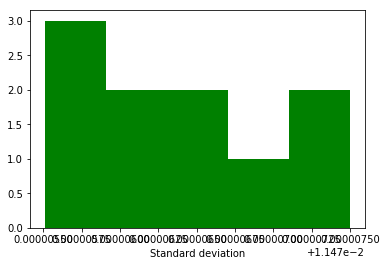

In [124]:
std, mean=hist_rel_err_mean_std_logcal(np.exp(gg_logcal),np.exp(sim_gains_logcal))
plt.hist(std,'auto',color='g')
#plt.hist(gg_amp_std_1m_logcal,'auto',color='g')
plt.xlabel('Standard deviation')
#plt.title('Logcal')
#plt.savefig('std_hist_logcal_5by5_nogainfluc_Tsys_50_pt1_dish_scatter')
plt.show()

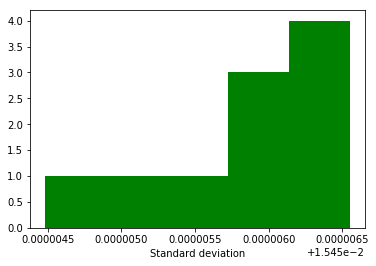

In [125]:
plt.hist(mean,'auto',color='g')
#plt.hist(gg_amp_std_1m_logcal,'auto',color='g')
plt.xlabel('Standard deviation')
#plt.title('Logcal')
#plt.savefig('std_hist_logcal_5by5_nogainfluc_Tsys_50_pt1_dish_scatter')
plt.show()